In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rxr
from PIL import Image
import numpy as np
from pathlib import Path
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_31055/900885294.py:12: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [4]:
print(torch.__version__)

2.0.1


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


print(f"Using {device} device")

Using cpu device


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
xdata = xr.open_dataset('/Volumes/DataDrive/1.40625deg/2m_temperature/2m_temperature_2017_1.40625deg.nc')

In [10]:
cropped_data = xdata['t2m'].sel(lat=slice(22.5,45),
                         lon=slice(265,287.5))

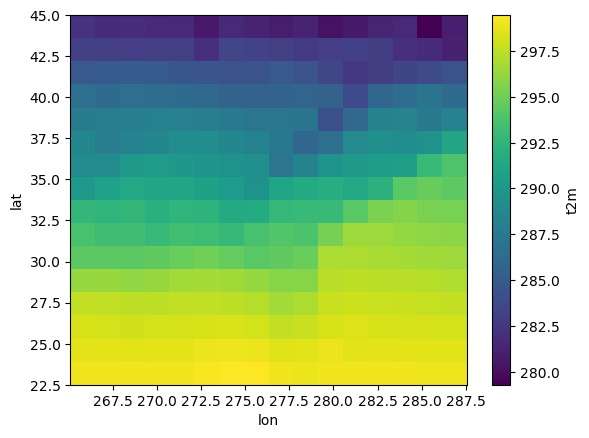

In [11]:
cropped_data.mean(dim='time').plot()

In [12]:
ndata = cropped_data.resample(time='1D').mean().to_numpy()

In [13]:
data_tensor = torch.from_numpy(ndata)

In [20]:
data_tensor.shape

torch.Size([365, 16, 16])

In [22]:
to_image = transforms.ToPILImage()

In [ ]:
to_image(data_tensor)

In [7]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
# non-square kernels and unequal stride and with padding and dilation
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
output = m(input)

In [2]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)

In [4]:
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))

In [5]:
m

Conv2d(16, 33, kernel_size=(3, 5), stride=(2, 1), padding=(4, 2))

In [53]:
timage = Image.open('/Volumes/DataDrive/Tiffs/2018-01-27.tif')

In [54]:
print(timage.format, timage.size, timage.mode)

TIFF (16, 16) F


In [55]:
timage.show()

In [41]:
rgbimg = Image.new("RGBA", timage.size)
rgbimg.paste(timage)
#rgbimg.save('foo.jpg')

In [42]:
rgbimg.show()

In [43]:
timage.point(lambda p: p*0.0039063096, mode='RGB')
rgbimg = timage.convert('RGB')
rgbimg.show() # check it out!

In [56]:
t_array = np.array(timage)

In [60]:
t_array.shape

(16, 16)

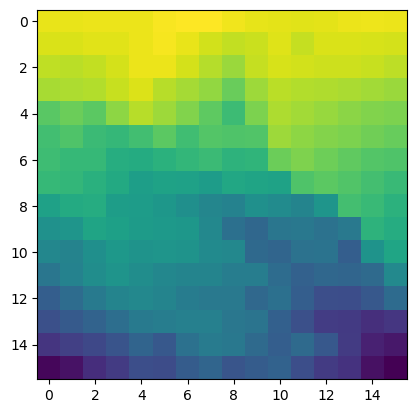

In [57]:
plt.imshow(t_array)

In [64]:
# get the input LR image from output HR image by blurring, cropping, then interpolating
h1,w1 = t_array.shape
blurred = np.zeros_like(t_array)
blurred = gaussian_filter(t_array, sigma = (0.55, 0.55))
half_res = blurred[::2, ::2]


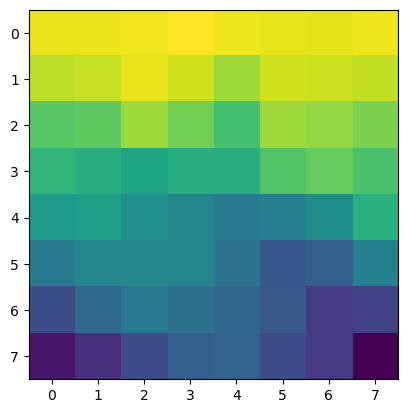

In [65]:
plt.imshow(half_res)

In [71]:
# Code involved in interpolating the blurred image back up to high res resolution
h2,w2 = half_res.shape
x = np.arange(h2)
y = np.arange(w2)
xnew = np.arange(0, h2, h2/h1)
ynew = np.arange(0, w2, w2/w1)
low_res = np.zeros_like(t_array)
f = RectBivariateSpline(x, y, half_res[:, :])
low_res[:, :] = f(xnew, ynew)

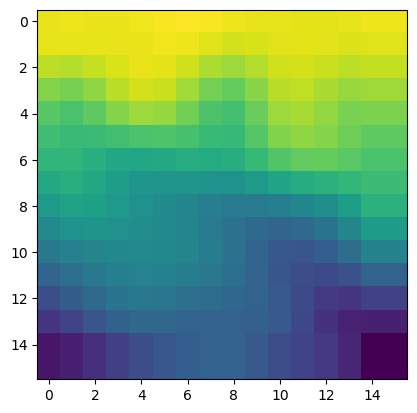

In [72]:
plt.imshow(low_res)

In [83]:
timg_list = list(Path('/Volumes/DataDrive/Tiffs').glob('*.tif'))

In [86]:
testf = Image.open(timg_list[0])

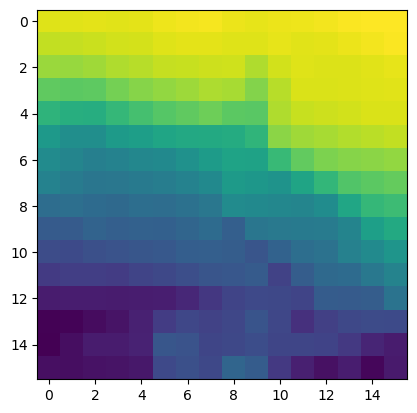

In [89]:
plt.imshow(np.array(testf))

In [8]:
class ClimateImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
        self.img_list = list(Path(img_dir).glob('*.tif'))
        # import required module

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        hr_image = Image.open(img_path)
        high_res = np.array(hr_image)
        
        # get the input LR image from output HR image by blurring, cropping, then interpolating
        h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
        blurred = gaussian_filter(high_res, sigma = (0.55, 0.55))
        half_res = blurred[::2, ::2]
        
        # Code involved in interpolating the blurred image back up to high res resolution
        h2,w2 = half_res.shape
        x = np.arange(h2)
        y = np.arange(w2)
        xnew = np.arange(0, h2, h2/h1)
        ynew = np.arange(0, w2, w2/w1)
        low_res = np.zeros_like(high_res)
        f = RectBivariateSpline(x, y, half_res[:, :])
        low_res[:, :] = f(xnew, ynew)


        low_res_t = torch.from_numpy(low_res).float()
        high_res_t = torch.from_numpy(high_res).float()
        
        return low_res_t, high_res_t


In [9]:
sr_data = ClimateImageDataset('/Volumes/DataDrive/Tiffs')

In [10]:
testx, testy = sr_data.__getitem__(3)

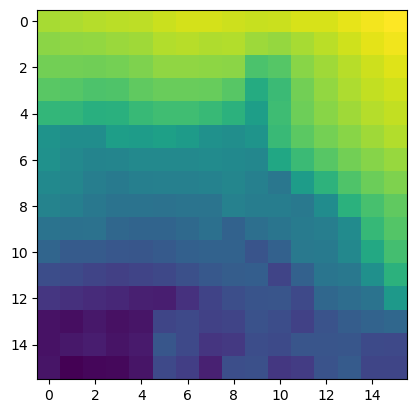

In [11]:
plt.imshow(testy)

In [12]:
mae = nn.L1Loss()
mse = nn.MSELoss()
 
print("MAE: %.3f" % mae(testx, testy))
print("MSE: %.3f" % mse(testx, testy))

MAE: 0.910
MSE: 1.921


In [ ]:
class sGenerator(nn.Module):
    def __init__(self, scale_factor) -> None:
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, padding=4), 
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class sDiscriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(128, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2), 

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2), 

            nn.AdaptiveAvgPool2d(1), 
            nn.Conv2d(512, 1024, kernel_size=1), 
            nn.LeakyReLU(0.2), 
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

    
class sResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual
    

class sUpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (up_scale ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x